In [1]:
import sys
sys.path.append('..')

In [2]:
import os
import torch
from pathlib import Path
import numpy as np
import pandas as pd
import wfdb
from tqdm import tqdm
from dataclasses import dataclass
from numpy.random import choice, shuffle
from scipy.signal import welch
from scipy.stats import entropy
from matplotlib import pyplot as plt
from timeit import default_timer as timer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from CommonFunctions import *
%matplotlib inline

In [3]:
svdb_dir = Path('./svdb_dir')
svdb_files = [file.stem for file in svdb_dir.glob('*.dat')]
print(svdb_files)

['800', '801', '802', '803', '804', '805', '806', '807', '808', '809', '810', '811', '812', '820', '821', '822', '823', '824', '825', '826', '827', '828', '829', '840', '841', '842', '843', '844', '845', '846', '847', '848', '849', '850', '851', '852', '853', '854', '855', '856', '857', '858', '859', '860', '861', '862', '863', '864', '865', '866', '867', '868', '869', '870', '871', '872', '873', '874', '875', '876', '877', '878', '879', '880', '881', '882', '883', '884', '885', '886', '887', '888', '889', '890', '891', '892', '893', '894']


In [4]:
time_window = 40
all_beats = []
all_annotations = []
for in_file in svdb_files:
    annotations = wfdb.rdann(str(os.path.join(svdb_dir, in_file)), 'atr')
    ann_symbols = annotations.symbol[5:-5]
    ann_locations = annotations.sample[5:-5]
    signal, fields = wfdb.rdsamp(str(os.path.join(svdb_dir, in_file)), channels=[0])
    signal = signal.flatten()
    for symbol, location in zip(ann_symbols, ann_locations):
        if symbol in ['N', 'S', 'V']:
            all_beats.append(signal[location - time_window: location + time_window])
            all_annotations.append(symbol)
all_beats = np.vstack(all_beats)
all_annotations = np.array(all_annotations)
print(all_beats.shape, all_annotations.shape)
print('no of N beats: ' + str(np.count_nonzero(all_annotations == 'N')))
print('no of S beats: ' + str(np.count_nonzero(all_annotations == 'S')))
print('no of V beats: ' + str(np.count_nonzero(all_annotations == 'V')))

(183707, 80) (183707,)
no of N beats: 161653
no of S beats: 12146
no of V beats: 9908


In [5]:
def randomly_pick_indexes(labels: np.array, quantity: int, proportions: dict[str, float]):
    group_labels = list(proportions.keys())
    group_proportions = [round(quantity * p) for p in proportions.values()]
    picks = []
    for label, proportion in zip(group_labels, group_proportions):
        group = np.where(labels == label)[0]
        picks.append(choice(group, size=proportion, replace=False))
    picks = np.hstack(picks)
    shuffle(picks)
    return picks

def plot_single_signal(figure, axes, beat, beat_annotation, fontsize=20, color='lime'):
    axes.plot(beat, color=color)
    axes.text(x=0.02, y=0.9, s=f'{beat_annotation}',
            transform = axes.transAxes, fontweight='bold', fontsize=fontsize)
    axes.axis(False)
    enhance_plot(figure, axes, glow=True, alpha_gradient=0.8, dpi=150)

def plot_random_beats(beats, beat_annotations, size, proportions, title=None, file=None):
    colors = {'N': 'lime', 'S': 'blue', 'V': 'red'}
    with plt.style.context('cyberpunk'):
        figure, axes = plt.subplots(*size, layout='constrained', figsize=(12, 12))
        fontsize = figure.axes[0].get_window_extent().transformed(figure.dpi_scale_trans.inverted())
        fontsize = fontsize.width * 0.15 * figure.dpi
        random_ann_labels = randomly_pick_indexes(beat_annotations, size[0] * size[1], proportions)
        for ax, random_index in zip(figure.axes, random_ann_labels):
            plot_single_signal(figure, ax, beats[random_index], beat_annotations[random_index],
                               fontsize=fontsize, color=colors[beat_annotations[random_index]])
        figure.suptitle(title)
    if file is None:
        figure.savefig(f'images/random_beat_images{"x".join([str(coord) for coord in size])}.png')
    else:
        figure.savefig(f'images/{file}.png')

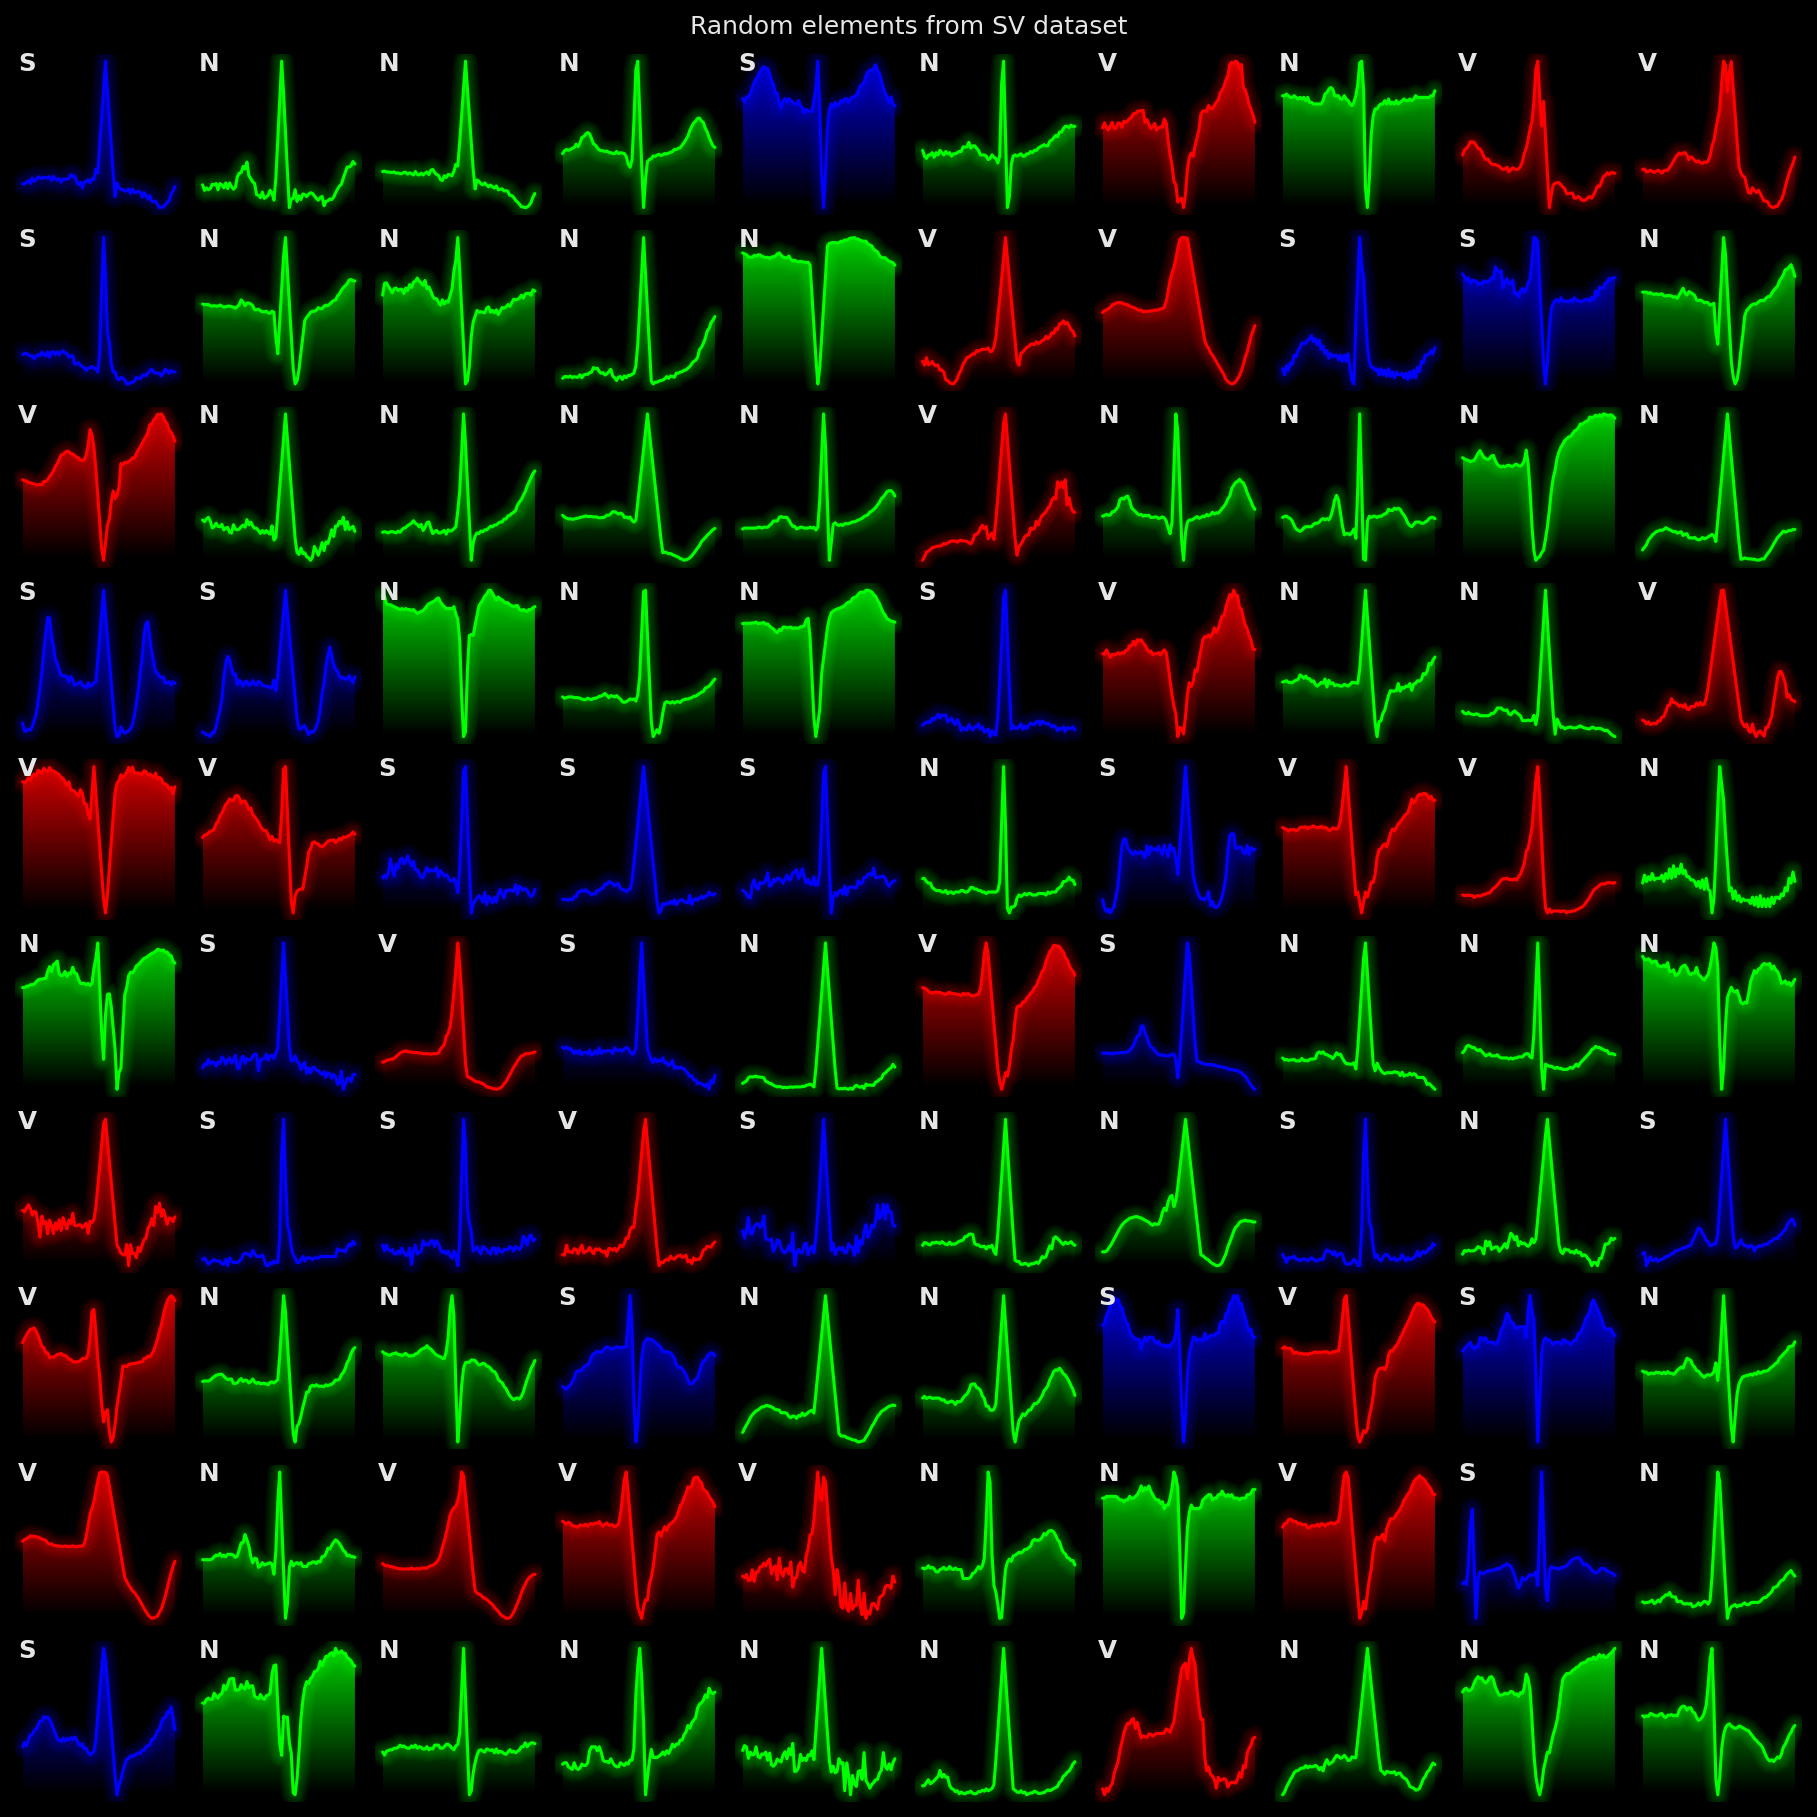

In [6]:
fig_title = 'Random elements from SV dataset'
props = {'N': 0.5, 'S': 0.25, 'V': 0.25}
plot_random_beats(all_beats, all_annotations, (10, 10), props, title=fig_title)

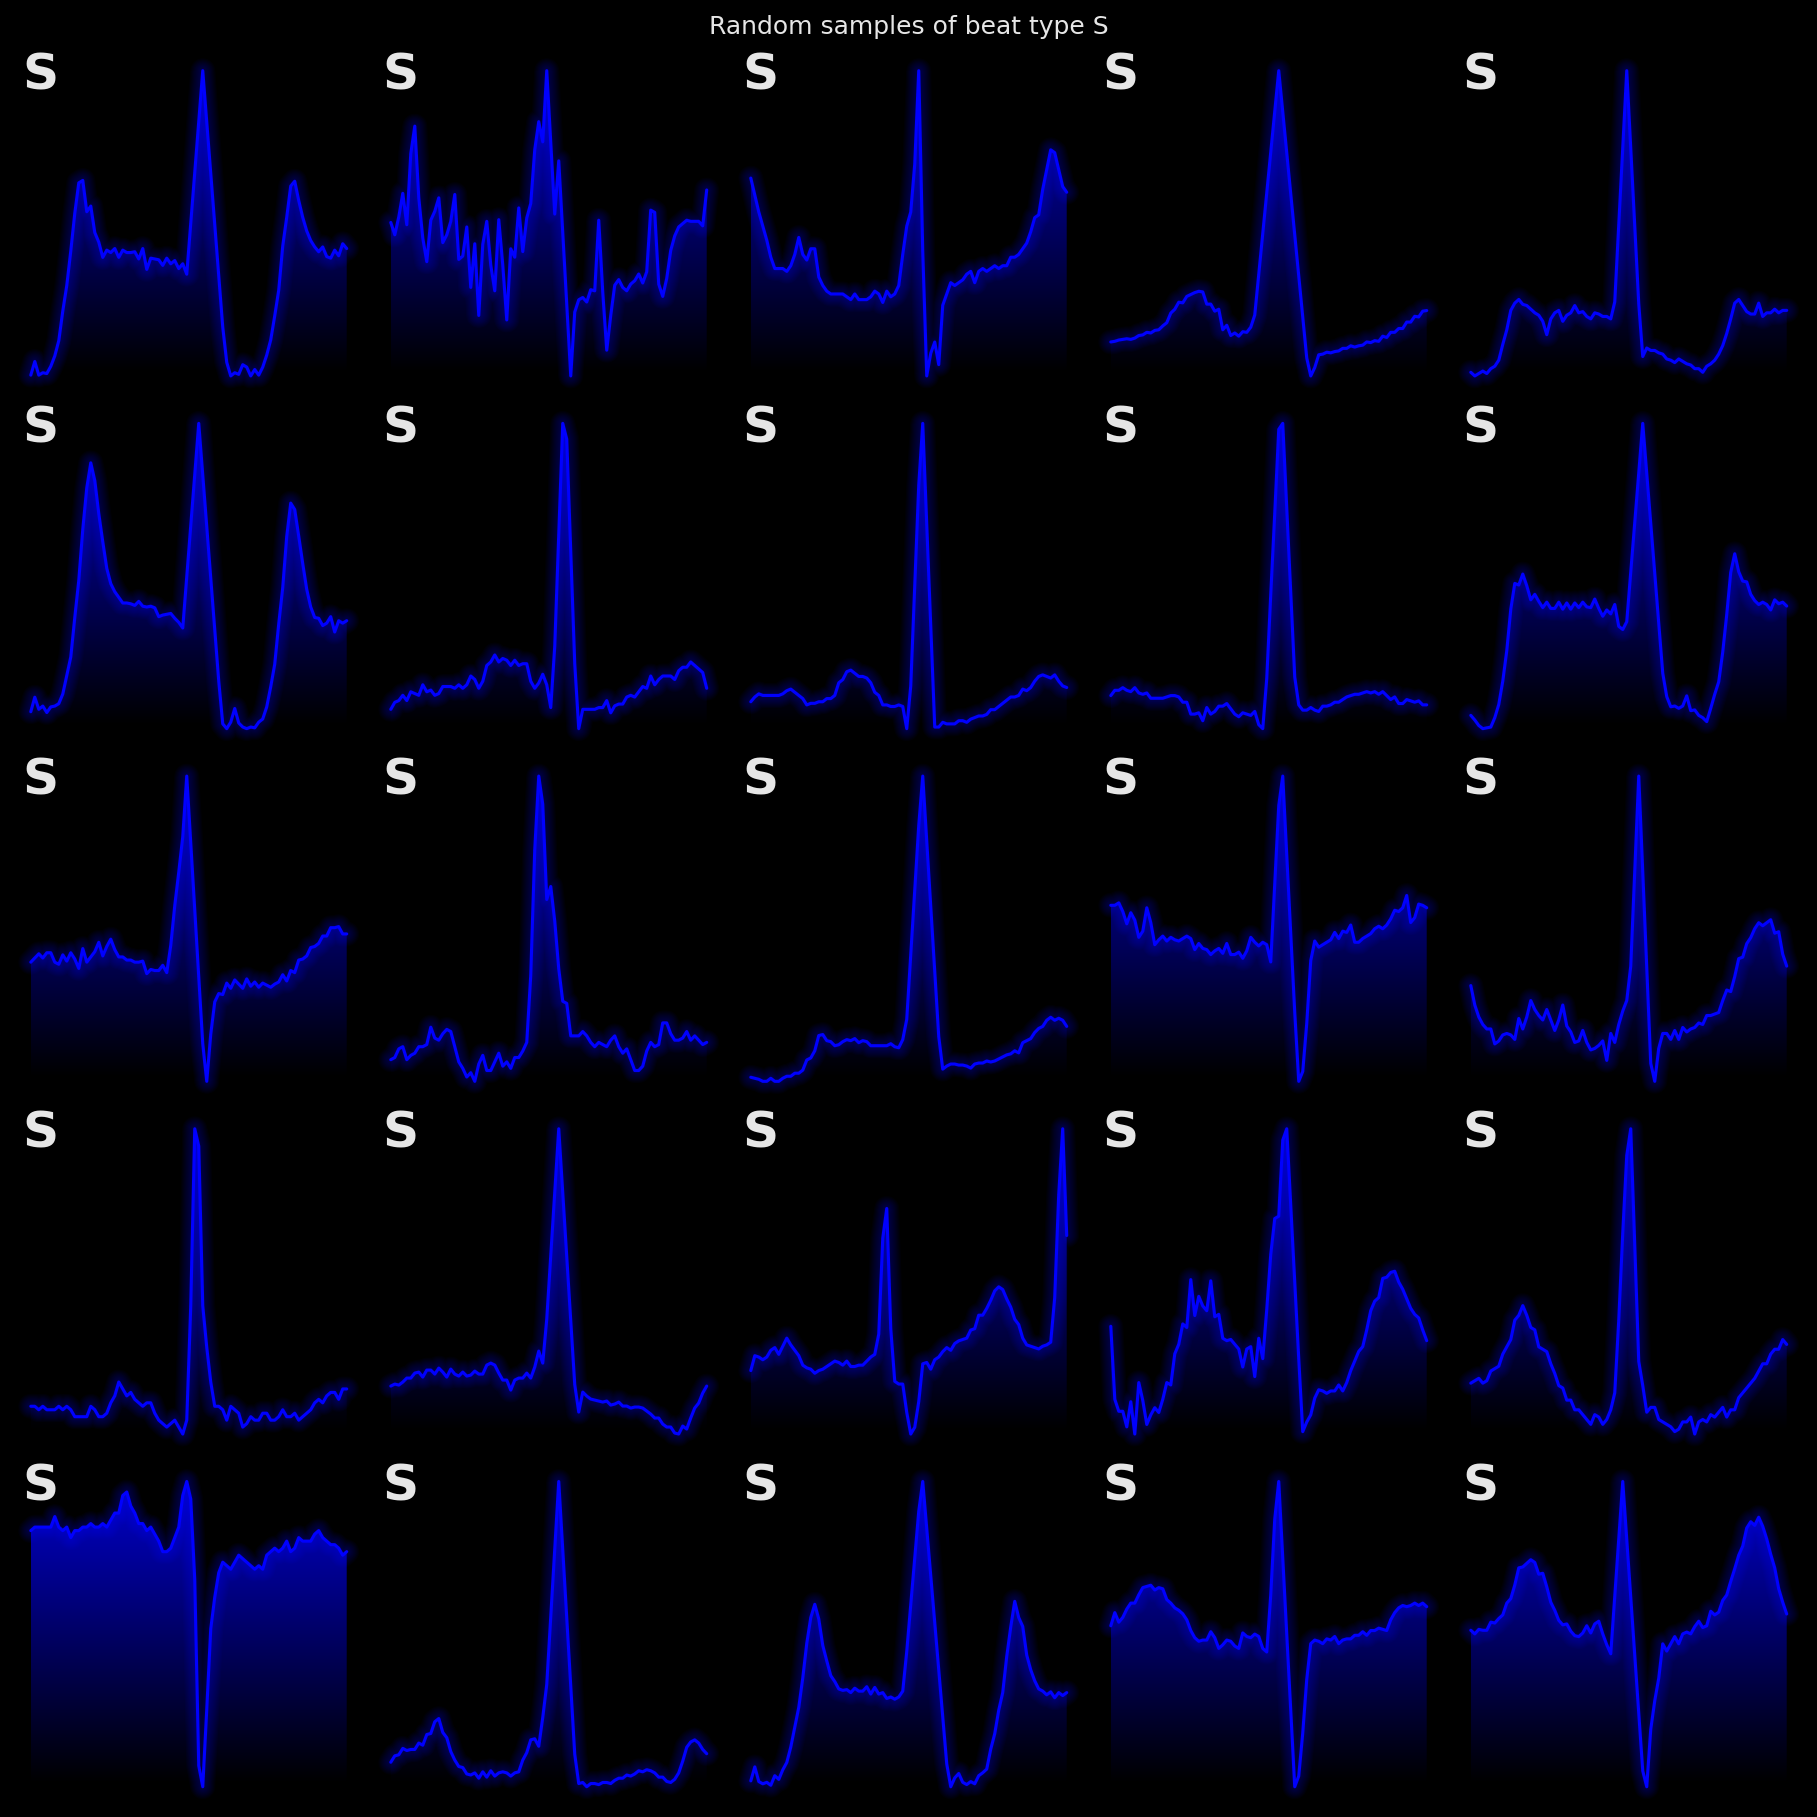

In [7]:
fig_title = 'Random samples of beat type S'
props = {'N': 0., 'S': 1., 'V': 0.}
plot_random_beats(all_beats, all_annotations, (5, 5), props, title=fig_title, file='typeS')

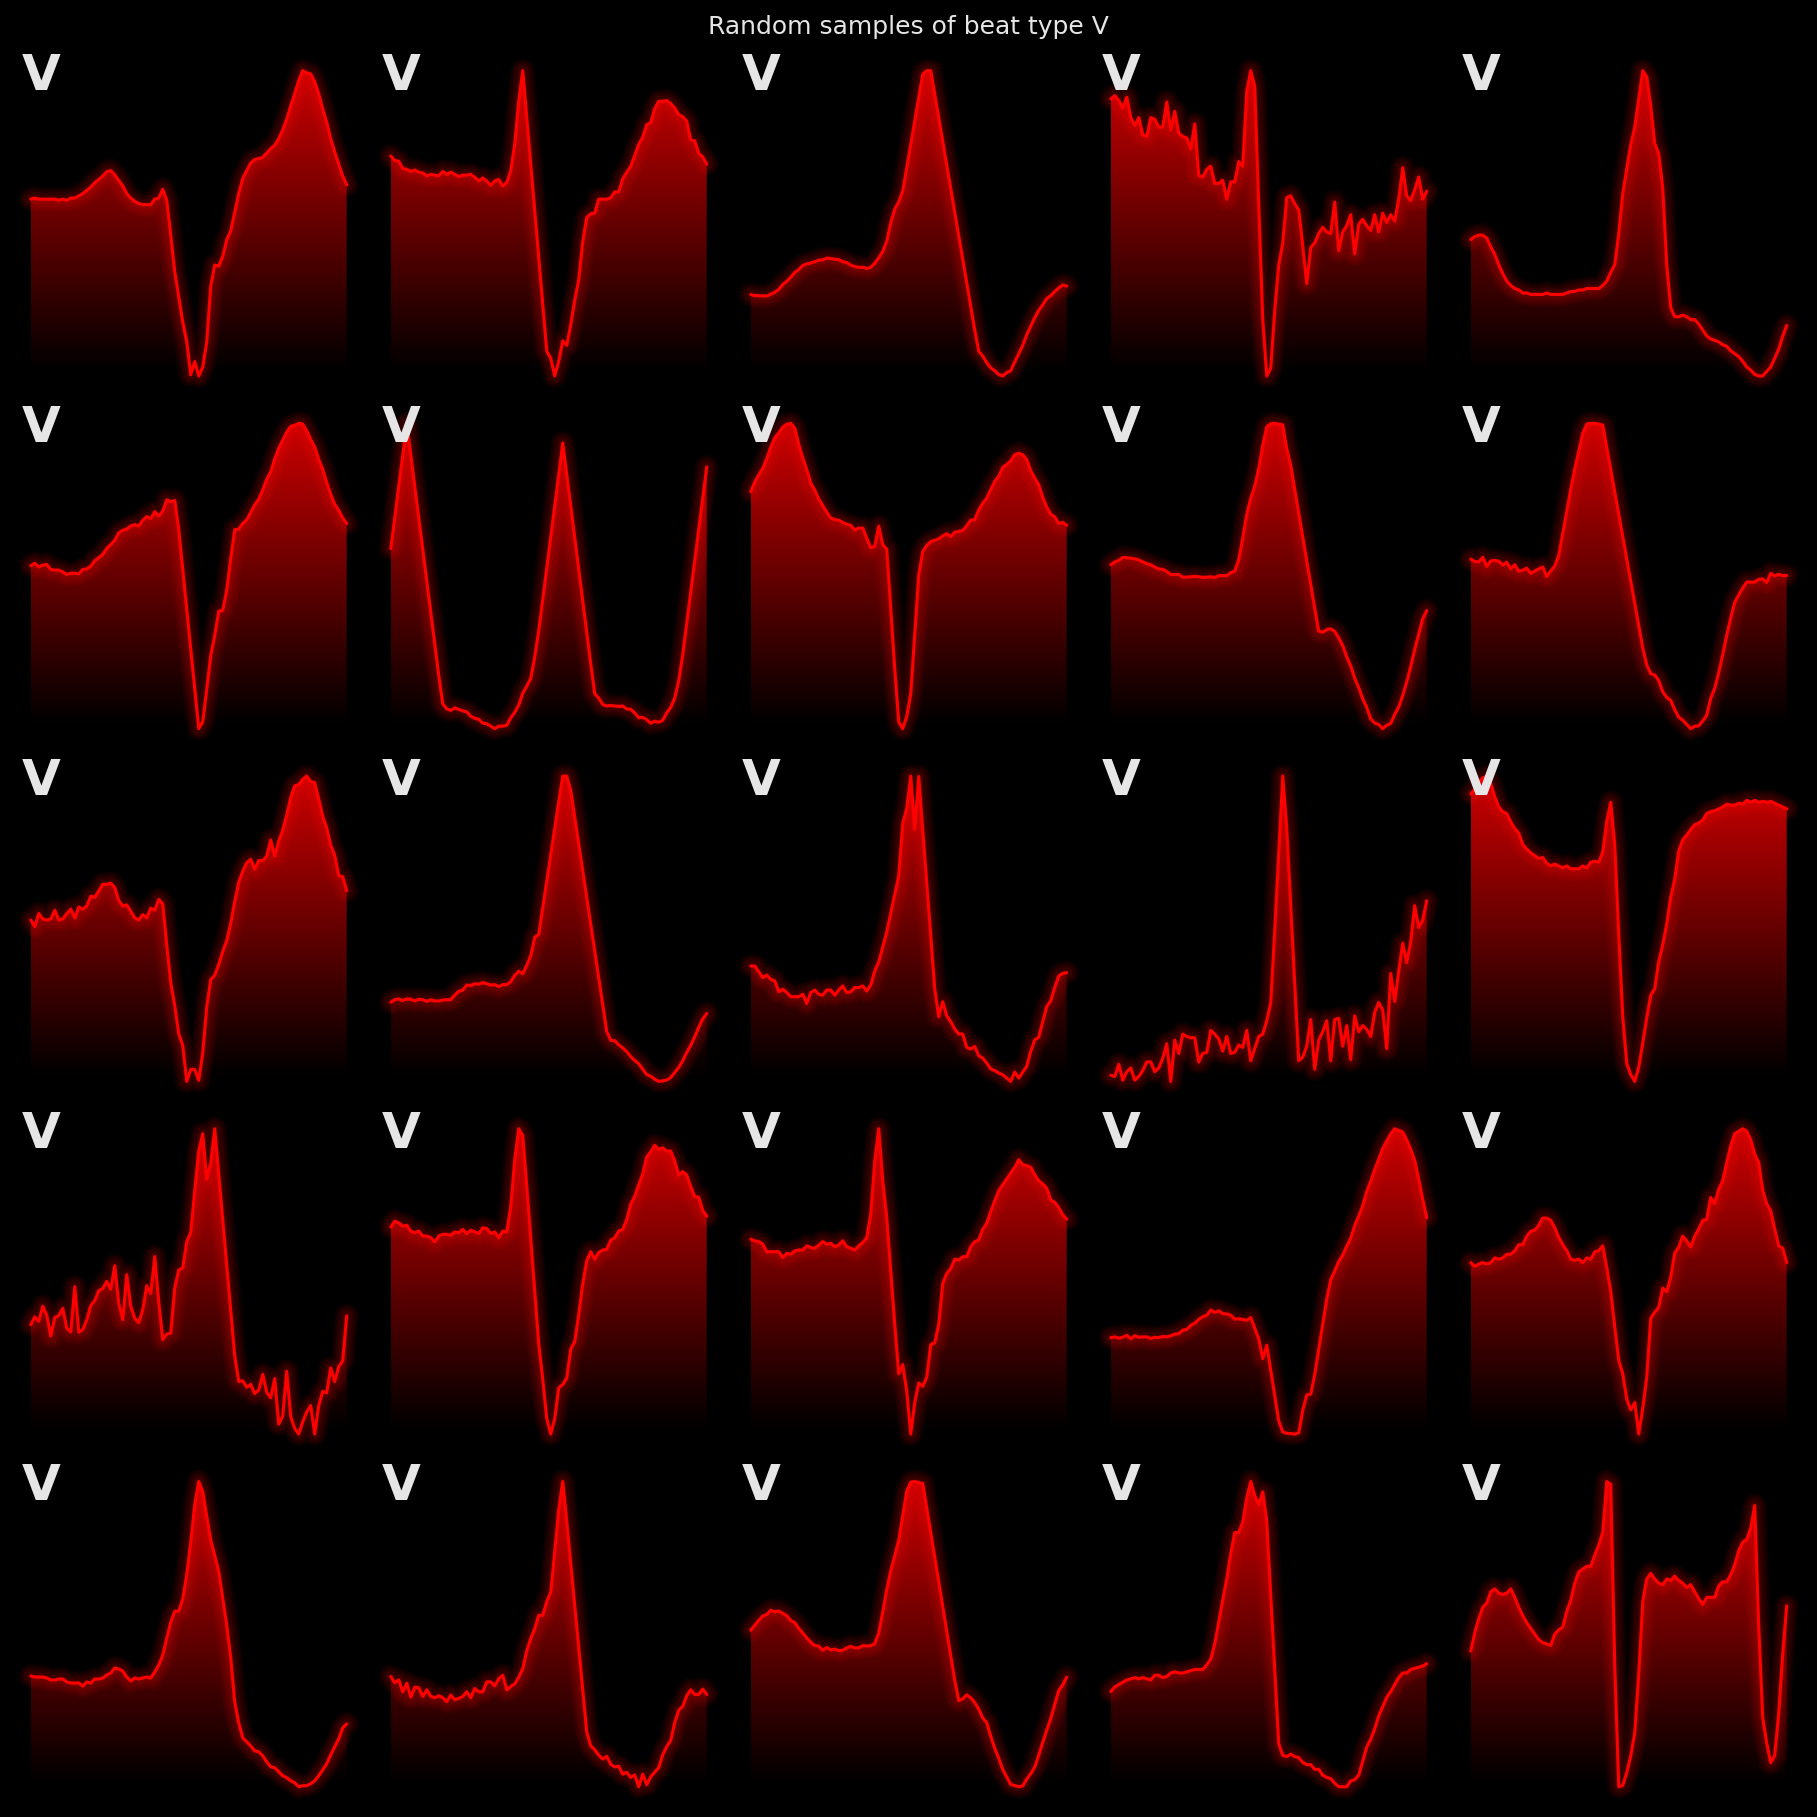

In [8]:
fig_title = 'Random samples of beat type V'
props = {'N': 0., 'S': 0., 'V': 1.}
plot_random_beats(all_beats, all_annotations, (5, 5), props, title=fig_title, file='typeV')

# Creating Custom Data-Loader object

### Scaling the data

In [9]:
standard_scaler = StandardScaler()
print(all_beats[:, 0].mean())
all_beats = standard_scaler.fit_transform(all_beats)
print(all_beats[:, 0].mean())

-0.08769039829728861
-7.859378461705452e-16


### Encoding labels

In [10]:
annotations_encoder = LabelEncoder()
annotations_encoded = annotations_encoder.fit_transform(all_annotations)
print(annotations_encoder.classes_)
print(annotations_encoded[:10])

['N' 'S' 'V']
[0 0 0 0 0 0 0 0 0 0]


In [11]:
@dataclass
class LearningParameters:
    batch_size: int = 128
    cpu_count: int = os.cpu_count()
    learning_rate: float = 0.05
    momentum: float = 0.97
    weight_decay: float = 0.001
    epochs: int = 150
    device: torch.device = torch.device('cpu')
    dropout: float = 0.3
    batch_norm: bool = True
PARAMS = LearningParameters()


def normalize_dataset(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)


class ECGDataset(Dataset):
    def __init__(self, waveforms, labels, transform=None):
        self.waveforms = torch.tensor(waveforms, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        waveform = self.waveforms[idx]
        if self.transform:
            waveform = self.transform(waveform)
        return waveform, self.labels[idx]
    

class ECGModel(nn.Module):
    def __init__(self, waveform_len, activation=nn.ReLU()):
        super(ECGModel, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(waveform_len, 256),
            activation,
            nn.Linear(256, 128),
            activation,
            nn.Linear(128, 64),
            activation
        )
        self.layer2 = nn.Sequential(
            nn.Linear(64, 32),
            activation,
            nn.Linear(32, 3),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.layer2(self.layer1(x))

In [12]:
def calculate_accuracy(y_pred, y_true, correct_beat_idx=0):
    acc_t = (y_pred == y_true).sum().item() / len(y_true)
    arrhythmia = (y_true != correct_beat_idx).sum().item()
    if arrhythmia == 0:
        return acc_t, None
    else:
        acc_a = torch.logical_and(
            y_pred == y_true, y_true != correct_beat_idx
        ).sum().item() / arrhythmia
        return acc_t, acc_a

def train_step(model, data_loader, loss_function, accuracy_function, optimizer, device):
    train_loss = 0
    acc_t, acc_a = 0, 0
    acc_a_correction = 0
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        # print(X.shape)
        y_pred = model(X)
        loss = loss_function(y_pred, y)
        train_loss += loss.item()
        acc_t_loop, acc_a_loop = accuracy_function(y_pred.argmax(dim=1), y)
        acc_t += acc_t_loop
        if acc_a_loop is None:
            acc_a_correction += 1
        else:
            acc_a += acc_a_loop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= (data_len := len(data_loader))
    acc_t /= data_len
    acc_a /= (data_len - acc_a_correction)
    return train_loss, acc_t, acc_a

def test_step(model, data_loader, loss_function, accuracy_function, device):
    test_loss = 0
    acc_t, acc_a = 0, 0
    acc_a_correction = 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            loss = loss_function(test_pred, y)
            test_loss += loss.item()
            acc_t_loop, acc_a_loop = accuracy_function(test_pred.argmax(dim=1), y)
            acc_t += acc_t_loop
            if acc_a_loop is None:
                acc_a_correction += 1
            else:
                acc_a += acc_a_loop
            
        test_loss /= (data_len := len(data_loader))
        acc_t /= data_len
        acc_a /= (data_len - acc_a_correction)
    return test_loss, acc_t, acc_a

def plot_loss_and_accuracy(title, epochs, img_title, losses, acc_ts, acc_as):
    data_parts = ['Train', 'Test']
    colors = ['red', 'lime']
    with plt.style.context('cyberpunk'):
        figure, axes = plt.subplot_mosaic(
            [['Loss', 'Loss'], ['Acct', 'Acca']],
            layout='constrained', figsize=(10, 8))
        x_data = range(1, epochs + 1)
        for loss, data_part, color in zip(losses, data_parts, colors):
            axes['Loss'].plot(x_data, loss, label=f'{data_part}: {loss[-1]:.3f}', color=color)
        axes['Loss'].set(ylabel='Loss', xlabel='epoch', title=title)
        for acc_t, data_part, color in zip(acc_ts, data_parts, colors):
            axes['Acct'].plot(x_data, acc_t, label=f'{data_part} Acc_t: {acc_t[-1]:.3f}%', color=color)
        axes['Acct'].set(ylabel='Acc_t', xlabel='epoch', title='Accuracy')
        for acc_a, data_part, color in zip(acc_as, data_parts, colors):
            axes['Acca'].plot(x_data, acc_a, label=f'{data_part} Acc_a: {acc_a[-1]:.3f}%', color=color)
        axes['Acca'].set(ylabel='Acc_a', xlabel='epoch', title='Arrhythmia accuracy')
        for ax in figure.axes:
            ax.legend()
            enhance_plot(figure, ax)
        figure.savefig(f'images/{img_title}.png')

def append_metrics(metric_lists, metrics):
    for metric_list, metric in zip(metric_lists, metrics):
        metric_list.append(metric)

model_performance = {}

In [13]:
split = int(0.7 * len(all_annotations))
ecg_dataset_train = ECGDataset(all_beats[:split], annotations_encoded[:split])
ecg_dataset_test = ECGDataset(all_beats[split:], annotations_encoded[split:])

train_dataloader = DataLoader(ecg_dataset_train, batch_size=PARAMS.batch_size, shuffle=True)
test_dataloader = DataLoader(ecg_dataset_test, batch_size=PARAMS.batch_size, shuffle=False)
len(train_dataloader), len(test_dataloader), len(all_beats[0])

(1005, 431, 80)

In [14]:
model = ECGModel(len(all_beats[0]))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.3)
model

ECGModel(
  (layer1): Sequential(
    (0): Linear(in_features=80, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=3, bias=True)
    (3): Softmax(dim=1)
  )
)

In [15]:
PARAMS.epochs = 15
train_time_start = timer()
train_loss, train_acc_t, train_acc_a = [], [], []
test_loss, test_acc_t, test_acc_a = [], [], []
for epoch in tqdm(range(PARAMS.epochs)):
    train_metrics = train_step(
        model, train_dataloader, loss_fn, 
        calculate_accuracy, optimizer, PARAMS.device)
    test_metrics = test_step(
        model, test_dataloader, loss_fn, 
        calculate_accuracy, PARAMS.device)
    append_metrics([train_loss, train_acc_t, train_acc_a], train_metrics)
    append_metrics([test_loss, test_acc_t, test_acc_a], test_metrics)
model_performance['Large Dataset'] = {'acc_t': test_acc_t[-1],
                                      'acc_a': test_acc_a[-1]}
train_time = timer() - train_time_start
print(f'Time: {train_time:.3f} seconds')

100%|██████████| 15/15 [01:06<00:00,  4.45s/it]

Time: 66.805 seconds


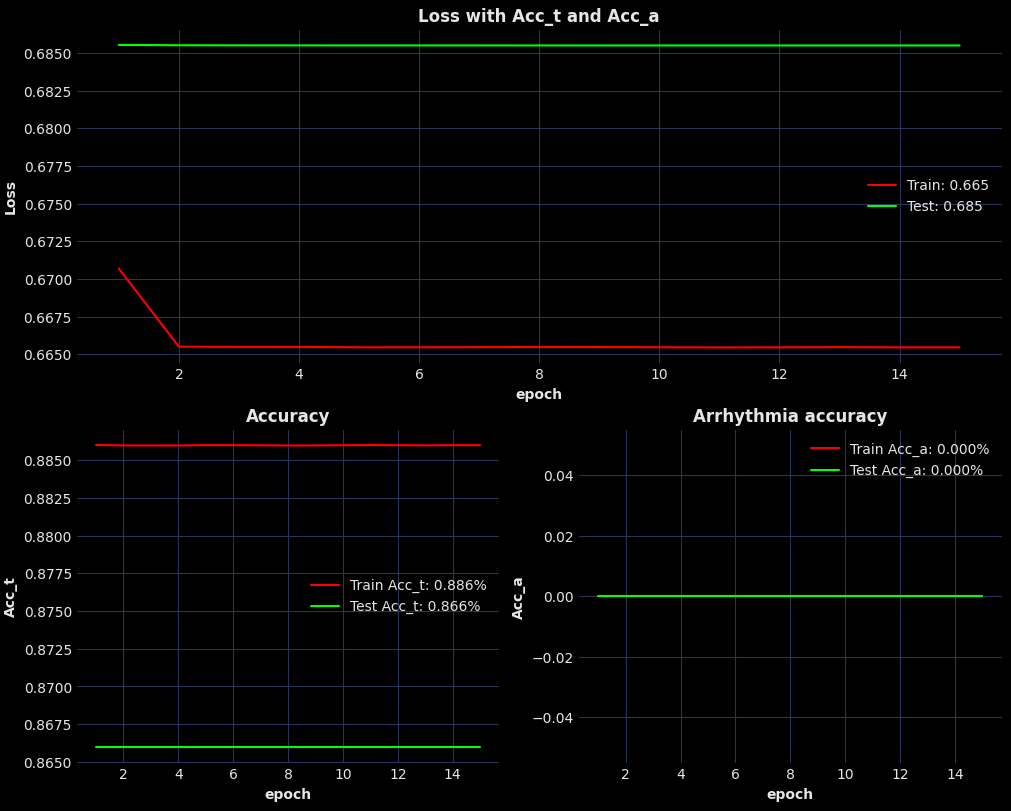

In [16]:
title = f'Loss with Acc_t and Acc_a'
plot_loss_and_accuracy(title, PARAMS.epochs, 'Train1',
                       [train_loss, test_loss],
                       [train_acc_t, test_acc_t],
                       [train_acc_a, test_acc_a]);

The number of N types is too large compared to others. Let's reduce it to 1/3

In [17]:
v_beats = np.count_nonzero(all_annotations == 'V')
picks = randomly_pick_indexes(all_annotations, 
                              3 * v_beats, 
                              {'N': 1/3, 'S': 1/3, 'V': 1/3})
reduced_beats = all_beats[picks]
reduced_annotations = all_annotations[picks]
print(f'Number of beat types "V": {v_beats}')
print(f'Reduced database length: {len(reduced_annotations)}')

reduced_annotations_encoded = annotations_encoder.transform(reduced_annotations)
print([(ann, idx) for idx, ann in 
       zip(reduced_annotations_encoded[:10], reduced_annotations[:10])])

Number of beat types "V": 9908
Reduced database length: 29724
[('N', 0), ('S', 1), ('S', 1), ('S', 1), ('S', 1), ('N', 0), ('S', 1), ('N', 0), ('N', 0), ('N', 0)]


In [18]:
PARAMS.epochs = 150
PARAMS.batch_size = 64
PARAMS.learning_rate = 0.05
PARAMS.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

split = int(0.7 * len(reduced_annotations))
ecg_dataset_train = ECGDataset(reduced_beats[:split], reduced_annotations_encoded[:split])
ecg_dataset_test = ECGDataset(reduced_beats[split:], reduced_annotations_encoded[split:])

train_dataloader = DataLoader(
    ecg_dataset_train, batch_size=PARAMS.batch_size, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(
    ecg_dataset_test, batch_size=PARAMS.batch_size, shuffle=False, pin_memory=True)
len(train_dataloader), len(test_dataloader), len(reduced_beats[0])

(326, 140, 80)

100%|██████████| 150/150 [03:23<00:00,  1.36s/it]


Time: 203.507 seconds


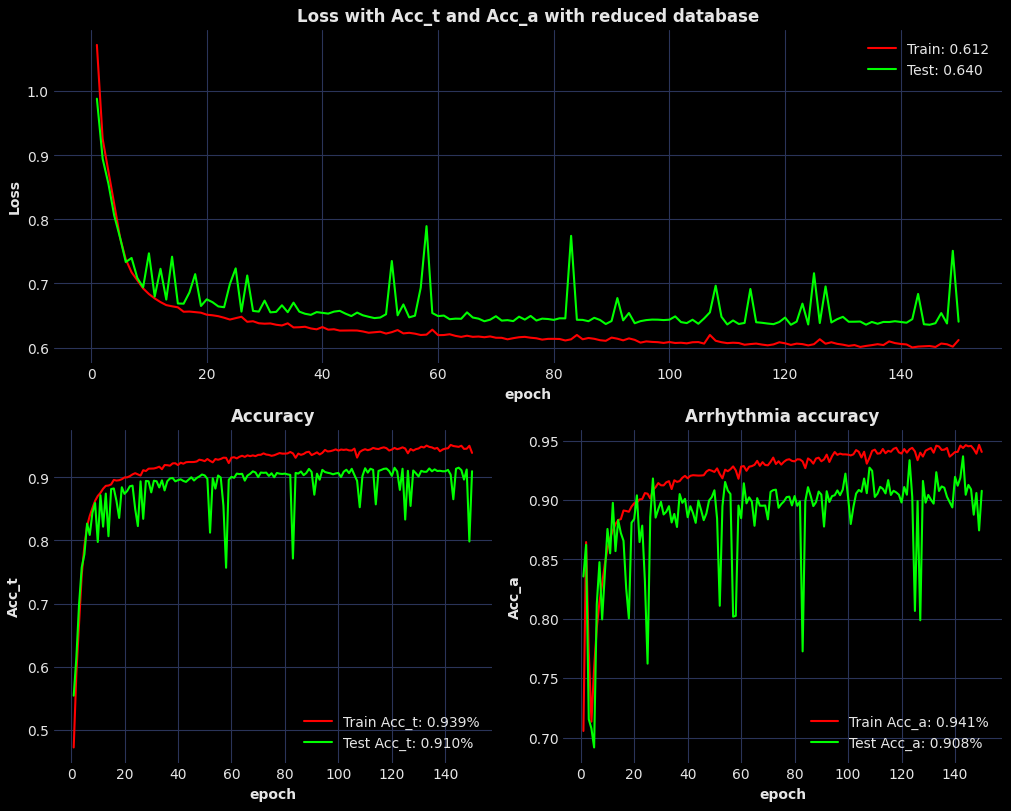

In [19]:
model = ECGModel(len(reduced_beats[0])).to(PARAMS.device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=PARAMS.learning_rate)
                            # momentum=params.momentum,
                            # weight_decay=params.weight_decay)
train_time_start = timer()
train_loss, train_acc_t, train_acc_a = [], [], []
test_loss, test_acc_t, test_acc_a = [], [], []
for epoch in tqdm(range(PARAMS.epochs)):
    train_metrics = train_step(
        model, train_dataloader, loss_fn, 
        calculate_accuracy, optimizer, PARAMS.device)
    test_metrics = test_step(
        model, test_dataloader, loss_fn, 
        calculate_accuracy, PARAMS.device)
    append_metrics([train_loss, train_acc_t, train_acc_a], train_metrics)
    append_metrics([test_loss, test_acc_t, test_acc_a], test_metrics)
train_time = timer() - train_time_start
model_performance['Balanced Dataset'] = {'acc_t': test_acc_t[-1],
                                      'acc_a': test_acc_a[-1]}
print(f'Time: {train_time:.3f} seconds')
title = f'Loss with Acc_t and Acc_a with reduced database'
plot_loss_and_accuracy(title, PARAMS.epochs, 'Train2',
                       [train_loss, test_loss],
                       [train_acc_t, test_acc_t],
                       [train_acc_a, test_acc_a]);

Second model will be 1D CNN

In [20]:
KERNEL_PARAMS = dict(kernel_size=3, stride=1, padding=1)
class ECGConvNet(nn.Module):
    # expects signal size 80
    def __init__(self, output_shape, activation=nn.ReLU()):
        super(ECGConvNet, self).__init__()
        layer_size = 64
        self.conv_layer = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=layer_size, **KERNEL_PARAMS),
            activation,
            nn.Conv1d(in_channels=layer_size, out_channels=layer_size, **KERNEL_PARAMS),
            activation,
            nn.MaxPool1d(kernel_size=2),
            nn.BatchNorm1d(layer_size)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), #(64, 40) -> 2560
            nn.Dropout(p=PARAMS.dropout, inplace=True),
            nn.Linear(in_features=64*40, out_features=512),
            activation,
            nn.Linear(in_features=512, out_features=256),
            activation,
            nn.Linear(in_features=256, out_features=128),
            activation,
            nn.Linear(in_features=128, out_features=output_shape),
            nn.Softmax(dim=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.classifier(self.conv_layer(x.unsqueeze(dim=1)))

100%|██████████| 150/150 [03:57<00:00,  1.58s/it]


Time: 237.102 seconds


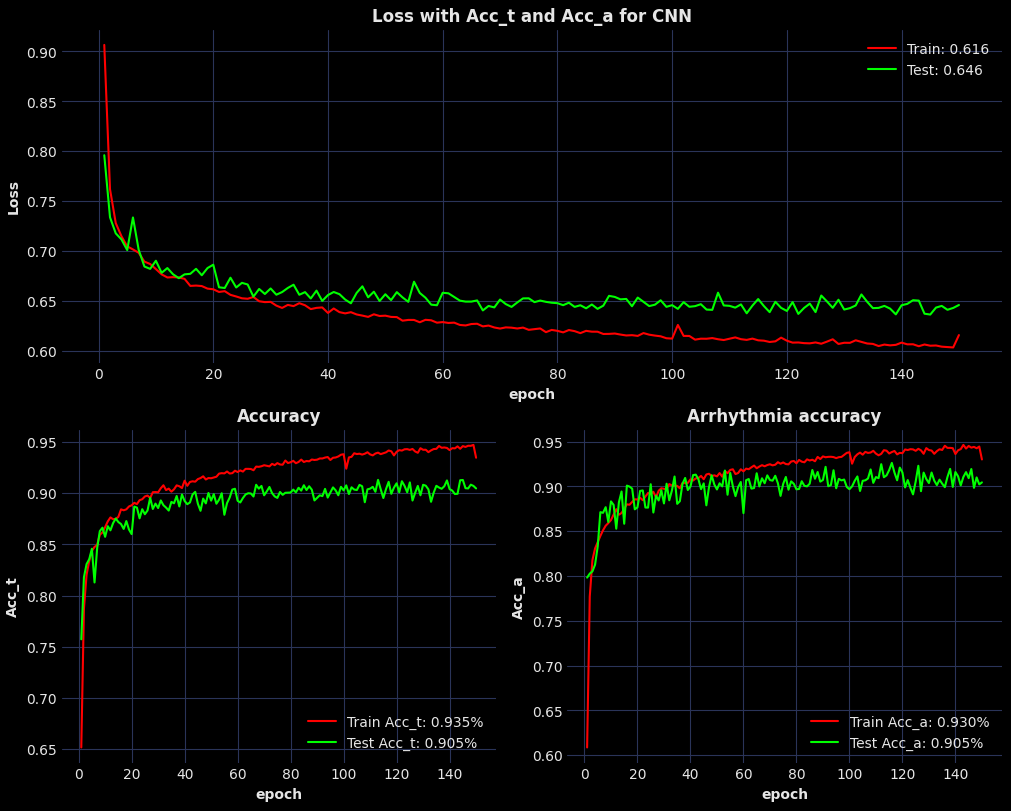

In [21]:
PARAMS.learning_rate = 0.01
model = ECGConvNet(3).to(PARAMS.device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=PARAMS.learning_rate,
                            momentum=0.9)
train_time_start = timer()
train_loss, train_acc_t, train_acc_a = [], [], []
test_loss, test_acc_t, test_acc_a = [], [], []
for epoch in tqdm(range(PARAMS.epochs)):
    train_metrics = train_step(
        model, train_dataloader, loss_fn, 
        calculate_accuracy, optimizer, PARAMS.device)
    test_metrics = test_step(
        model, test_dataloader, loss_fn, 
        calculate_accuracy, PARAMS.device)
    append_metrics([train_loss, train_acc_t, train_acc_a], train_metrics)
    append_metrics([test_loss, test_acc_t, test_acc_a], test_metrics)
model_performance['CNN'] = {'acc_t': test_acc_t[-1],
                            'acc_a': test_acc_a[-1]}
train_time = timer() - train_time_start
print(f'Time: {train_time:.3f} seconds')
title = f'Loss with Acc_t and Acc_a for CNN'
plot_loss_and_accuracy(title, PARAMS.epochs, 'Train3',
                       [train_loss, test_loss],
                       [train_acc_t, test_acc_t],
                       [train_acc_a, test_acc_a]);

Other features:
* MAV - Mean Absolute Value
* RMS - Root Mean Square
* SSC - Slope Sign Changes (number of  times the signal slope changes sign)
* Standard Deviation
* Mean Frequency
* Spectral Entropy

In [22]:
def mean_absolute_value(x: np.array) -> float:
    return np.mean(np.abs(x))

def root_mean_square(x: np.array) -> float:
    return np.sqrt(np.mean(np.square(x)))

def slope_sign_changes(x: np.array) -> int:
    return np.sum(np.diff(np.sign(np.diff(x))) != 0)

def standard_deviation(x: np.array) -> float:
    return np.std(x)

def mean_frequency(x: np.array, fft_params: tuple[np.array] = None) -> float:
    if fft_params is None:
        frequencies, psd = welch(x, nperseg=len(x))
    else:
        frequencies, psd = fft_params
    return np.sum(frequencies * psd) / np.sum(psd)

def spectral_entropy(x: np.array, psd: np.array = None) -> float:
    if psd is None:
        _, psd = welch(x, nperseg=len(x))
    return entropy(psd / np.sum(psd))

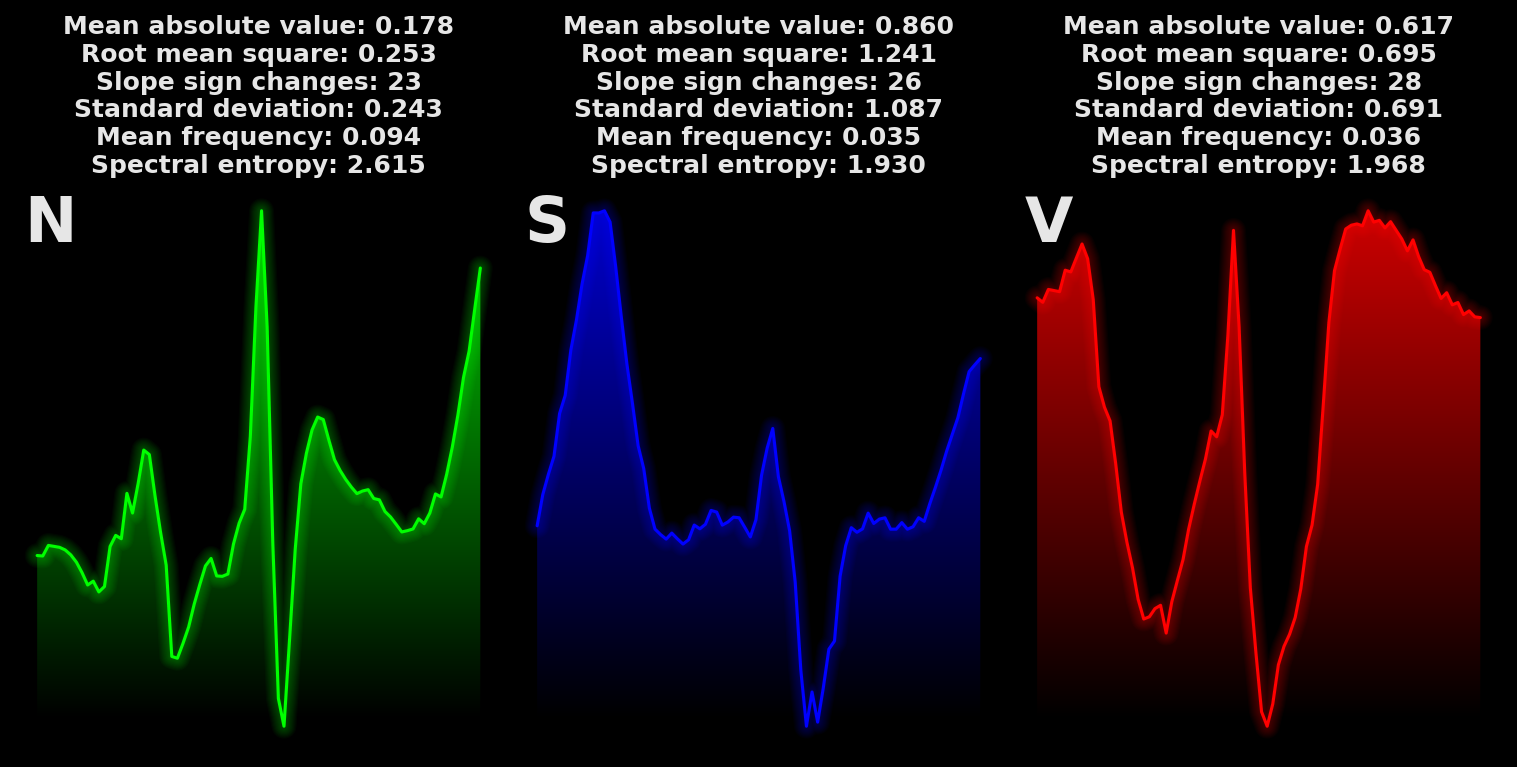

In [23]:
choices = [np.where(reduced_annotations[:100] == beat_type)[0][0] for beat_type in ['N', 'S', 'V']]
example_signals, example_annotations = reduced_beats[choices], reduced_annotations[choices]
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 3, layout='constrained', figsize=(10, 5))
    for ax, sig, ann, color in zip(figure.axes, example_signals, 
                            example_annotations, ['lime', 'blue', 'red']):
        title = (f'Mean absolute value: {mean_absolute_value(sig):.3f}\n'
                 f'Root mean square: {root_mean_square(sig):.3f}\n'
                 f'Slope sign changes: {slope_sign_changes(sig)}\n'
                 f'Standard deviation: {standard_deviation(sig):.3f}\n'
                 f'Mean frequency: {mean_frequency(sig):.3f}\n'
                 f'Spectral entropy: {spectral_entropy(sig):.3f}')
        ax.set(title=title)
        plot_single_signal(figure, ax, sig, ann, color=color, fontsize=30)
    figure.savefig('images/FeaturesComparison.png')

In [24]:
reduced_features_df = []
for index, sig in enumerate(reduced_beats):
    fft_params = welch(sig, nperseg=len(sig))
    features = {
        'MAV': mean_absolute_value(sig),
        'RMS': root_mean_square(sig),
        'SSC': slope_sign_changes(sig),
        'STD': standard_deviation(sig),
        'MF': mean_frequency(sig, fft_params=fft_params),
        'SE': spectral_entropy(sig, psd=fft_params[1])
    }
    reduced_features_df.append(features)
reduced_features_df = pd.DataFrame(reduced_features_df)
reduced_features_df.head()

,MAV,RMS,SSC,STD,MF,SE
0,0.178246,0.253199,23,0.243470,0.093659,2.614920
1,0.859961,1.240596,26,1.086839,0.034872,1.929737
2,0.343693,0.429615,42,0.374025,0.045467,2.153413
3,0.449317,0.561349,34,0.560983,0.057491,2.146408
4,1.162992,1.492545,30,1.469741,0.037610,1.704369


Creating new classes:
* Dataloader object that will store both signals and features
* New MLP that will combine signals and features
* New CNN that will combine signals and features

In [25]:
class ECGDatasetFeatures(Dataset):
    def __init__(self, waveforms: np.array, labels: np.array, features: pd.DataFrame):
        self.waveforms = torch.tensor(waveforms, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        
        self.num_of_features = features.values.shape[1]
        self.features = torch.tensor(
            StandardScaler().fit_transform(features.values), 
            dtype=torch.float32)
        
    def get_number_of_features(self):
        return self.num_of_features
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        waveforms_with_features = torch.cat(
            (self.waveforms[idx, None], self.features[idx, None]), dim=1)[0]
        return waveforms_with_features, self.labels[idx]


class ECGModelFeatures(nn.Module):
    def __init__(self, waveform_len, num_of_features, num_of_classes, activation=nn.ReLU()):
        super(ECGModelFeatures, self).__init__()
        self.num_of_features = num_of_features
        
        self.signal_layer = nn.Sequential(
            nn.Linear(waveform_len, 1024), activation,
            nn.Linear(1024, 512), activation,
            nn.Linear(512, 256), activation,
            nn.Linear(256, 128), activation
        )
        
        self.feature_layer = nn.Sequential(
            nn.Linear(num_of_features, 64), activation,
            nn.Linear(64, 32), activation,
            nn.Linear(32, 16), activation,
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128 + 16, 64), activation,
            nn.Linear(64, 32), activation,
            nn.Linear(32, num_of_classes),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.classifier(torch.cat((
            self.signal_layer(x[:, :-self.num_of_features]), 
            self.feature_layer(x[:, -self.num_of_features:])
        ), dim=1))

In [26]:
PARAMS.batch_size = 64

split = int(0.7 * len(reduced_annotations))
ecg_dataset_train = ECGDatasetFeatures(waveforms=reduced_beats[:split],
                                       labels=reduced_annotations_encoded[:split],
                                       features=reduced_features_df.iloc[:split])
ecg_dataset_test = ECGDatasetFeatures(waveforms=reduced_beats[split:],
                                      labels=reduced_annotations_encoded[split:],
                                      features=reduced_features_df.iloc[split:])
train_dataloader = DataLoader(
    ecg_dataset_train, batch_size=PARAMS.batch_size, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(
    ecg_dataset_test, batch_size=PARAMS.batch_size, shuffle=False, pin_memory=True)
len(train_dataloader), len(test_dataloader), len(reduced_beats[0])

(326, 140, 80)

100%|██████████| 150/150 [06:23<00:00,  2.56s/it]


Time: 383.617 seconds


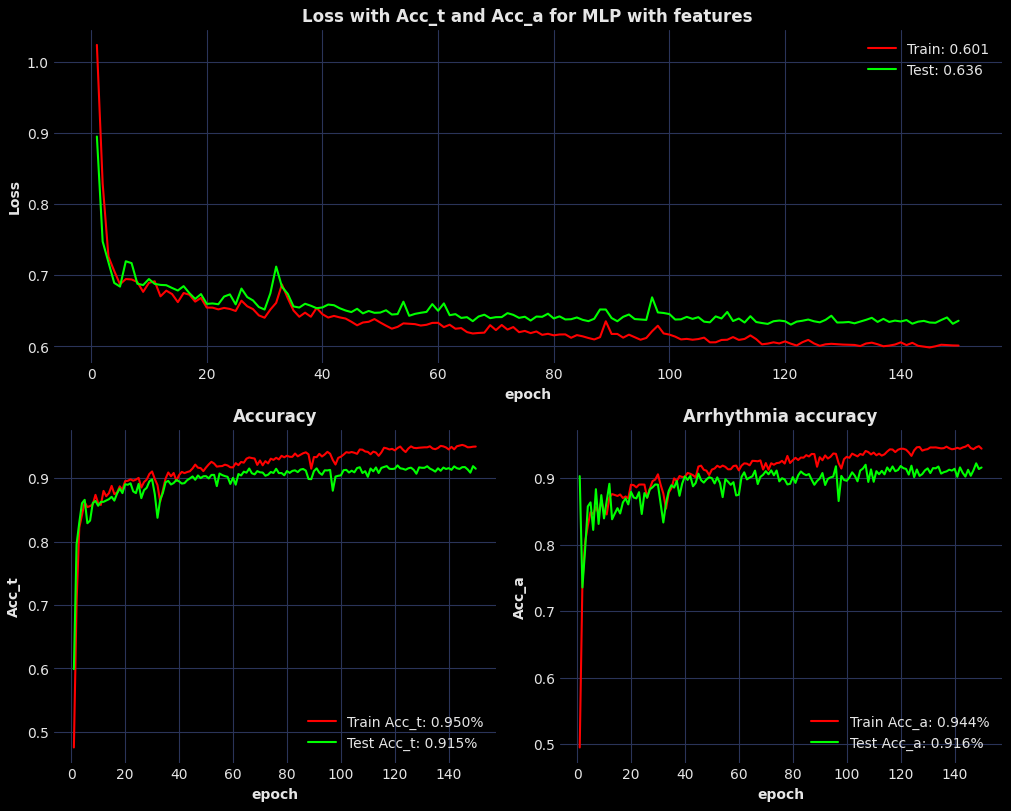

In [27]:
PARAMS.learning_rate = 0.01
PARAMS.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ECGModelFeatures(waveform_len=len(reduced_beats[0]),
                         num_of_features=reduced_features_df.shape[1],
                         num_of_classes=len(annotations_encoder.classes_)).to(PARAMS.device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=PARAMS.learning_rate,
                            momentum=PARAMS.momentum)
train_time_start = timer()
train_loss, train_acc_t, train_acc_a = [], [], []
test_loss, test_acc_t, test_acc_a = [], [], []
for epoch in tqdm(range(PARAMS.epochs)):
    train_metrics = train_step(
        model, train_dataloader, loss_fn, 
        calculate_accuracy, optimizer, PARAMS.device)
    test_metrics = test_step(
        model, test_dataloader, loss_fn, 
        calculate_accuracy, PARAMS.device)
    append_metrics([train_loss, train_acc_t, train_acc_a], train_metrics)
    append_metrics([test_loss, test_acc_t, test_acc_a], test_metrics)
model_performance['MLP with Features'] = {'acc_t': test_acc_t[-1],
                                          'acc_a': test_acc_a[-1]}
train_time = timer() - train_time_start
print(f'Time: {train_time:.3f} seconds')
title = f'Loss with Acc_t and Acc_a for MLP with features'
plot_loss_and_accuracy(title, PARAMS.epochs, 'Train4',
                       [train_loss, test_loss],
                       [train_acc_t, test_acc_t],
                       [train_acc_a, test_acc_a]);

CNN with features

In [28]:
KERNEL_PARAMS = dict(kernel_size=3, stride=1, padding=1)
class ECGConvNetFeatures(nn.Module):
    def __init__(self, waveform_len, num_of_features, num_of_classes, activation=nn.ReLU()):
        super(ECGConvNetFeatures, self).__init__()
        conv_layer_size = 64
        self.num_of_features = num_of_features
        self.conv_layer = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=conv_layer_size, **KERNEL_PARAMS),
            activation,
            nn.Conv1d(in_channels=conv_layer_size, out_channels=conv_layer_size, **KERNEL_PARAMS),
            activation,
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=conv_layer_size, out_channels=conv_layer_size, **KERNEL_PARAMS),
            activation,
            nn.MaxPool1d(kernel_size=2),
            nn.BatchNorm1d(conv_layer_size),
            nn.Flatten()
        )
        
        self.feature_layer = nn.Sequential(
            nn.Linear(num_of_features, 64), activation,
            nn.Linear(64, 32), activation,
            nn.Linear(32, 16), activation,
        )
        
        self.classifier = nn.Sequential(
            nn.Linear((conv_layer_size * (waveform_len // 4)) + 16, 512), activation,
            nn.Linear(512, 256), activation,
            nn.Linear(256, 128), activation,
            nn.Linear(128, 64), activation,
            nn.Linear(64, 32), activation,
            nn.Linear(32, num_of_classes),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.classifier(torch.cat((
            self.conv_layer(x[:, :-self.num_of_features].unsqueeze(dim=1)),
            self.feature_layer(x[:, -self.num_of_features:])
        ), dim=1))

100%|██████████| 150/150 [06:28<00:00,  2.59s/it]


Time: 388.185 seconds


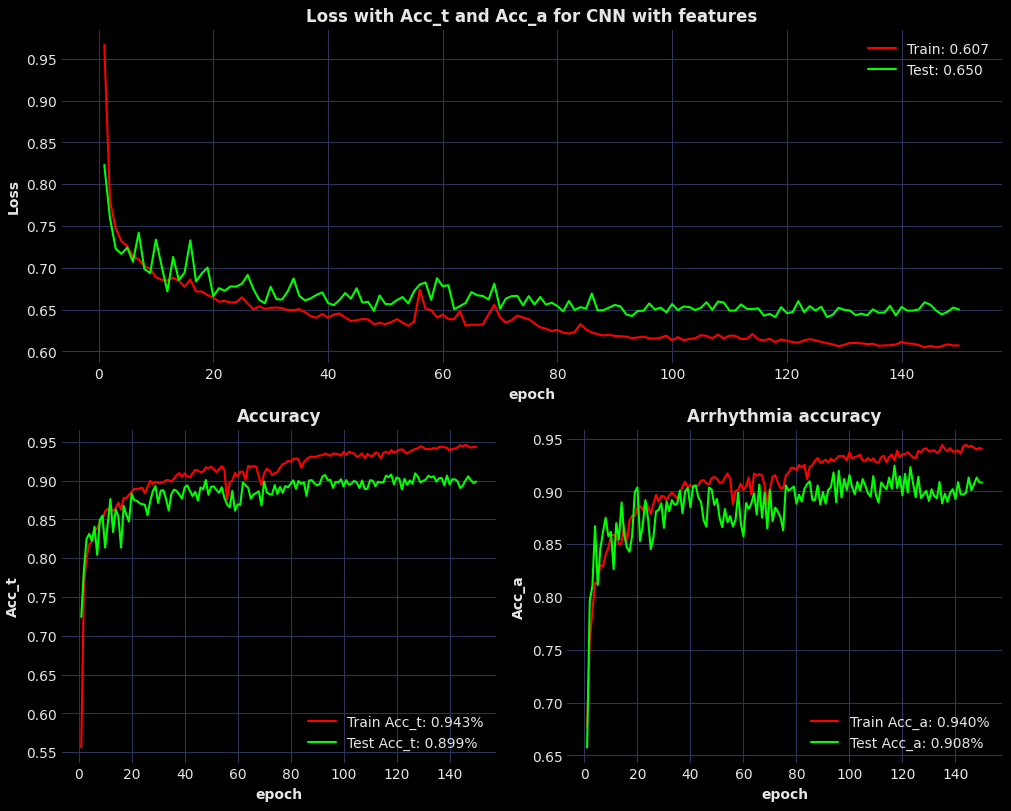

In [29]:
PARAMS.learning_rate = 0.01
PARAMS.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ECGConvNetFeatures(waveform_len=len(reduced_beats[0]),
                           num_of_features=reduced_features_df.shape[1],
                           num_of_classes=len(annotations_encoder.classes_)).to(PARAMS.device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=PARAMS.learning_rate,
                            momentum=PARAMS.momentum)
train_time_start = timer()
train_loss, train_acc_t, train_acc_a = [], [], []
test_loss, test_acc_t, test_acc_a = [], [], []
for epoch in tqdm(range(PARAMS.epochs)):
    train_metrics = train_step(
        model, train_dataloader, loss_fn, 
        calculate_accuracy, optimizer, PARAMS.device)
    test_metrics = test_step(
        model, test_dataloader, loss_fn, 
        calculate_accuracy, PARAMS.device)
    append_metrics([train_loss, train_acc_t, train_acc_a], train_metrics)
    append_metrics([test_loss, test_acc_t, test_acc_a], test_metrics)
model_performance['CNN with Features'] = {'acc_t': test_acc_t[-1],
                                          'acc_a': test_acc_a[-1]}
train_time = timer() - train_time_start
print(f'Time: {train_time:.3f} seconds')
title = f'Loss with Acc_t and Acc_a for CNN with features'
plot_loss_and_accuracy(title, PARAMS.epochs, 'Train5',
                       [train_loss, test_loss],
                       [train_acc_t, test_acc_t],
                       [train_acc_a, test_acc_a]);

# Comparing results

In [30]:
model_performance

{'Large Dataset': {'acc_t': 0.8659546530845755, 'acc_a': 0.0},
 'Balanced Dataset': {'acc_t': 0.9098315746753247,
  'acc_a': 0.9078580984572697},
 'CNN': {'acc_t': 0.9047077922077922, 'acc_a': 0.9045225395317019},
 'MLP with Features': {'acc_t': 0.9150974025974027,
  'acc_a': 0.9161229602753687},
 'CNN with Features': {'acc_t': 0.8989042207792207,
  'acc_a': 0.908353900130853}}

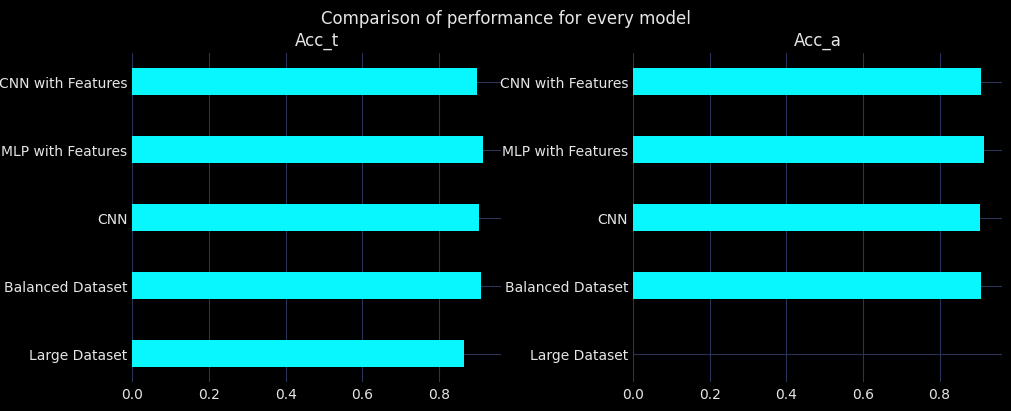

In [33]:
acc_t_perf, acc_a_perf = [], []
for arr in model_performance.values():
    acc_t_perf.append(arr['acc_t'])
    acc_a_perf.append(arr['acc_a'])
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 2, layout='constrained', figsize=(10, 4))
    axes[0].barh(list(model_performance.keys()), acc_t_perf, height=0.4)
    axes[1].barh(list(model_performance.keys()), acc_a_perf, height=0.4)
    figure.set_facecolor('black')
    axes[0].set_facecolor('black')
    axes[1].set_facecolor('black')
    axes[0].set(title='Acc_t')
    axes[1].set(title='Acc_a')
    figure.suptitle(f'Comparison of performance for every model')
    figure.savefig('images/comparison.png')